# Mediapiple Facemesh + Texture

## references
- https://github.com/google/mediapipe/issues/1698
- https://github.com/google/mediapipe/issues/1798
- https://github.com/google/mediapipe/tree/master/mediapipe/modules/face_geometry/data
- https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
- https://github.com/google/mediapipe/blob/e6c19885c6d3c6f410c730952aeed2852790d306/mediapipe/modules/face_geometry/data/canonical_face_model.obj

In [1]:
import os
#list the current work dir
os.getcwd()

'/Users/joeljohnson/Desktop/Joel/mediapipe-facemesh'

In [6]:
# # %matplotlib inline


import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp

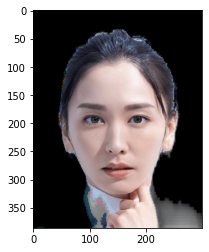

In [7]:
img_path2 = "/Users/joeljohnson/Desktop/Joel/mediapipe-facemesh/data/gakki.jpg"
img_ori = skimage.io.imread(img_path2)

mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

RGB = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
# get the result
results = selfie_segmentation.process(RGB)
# extract segmented mask
mask = results.segmentation_mask
# apply mask to the original image
mask = np.stack((mask,)*3, axis=-1)
mask = mask * 255
mask = mask.astype(np.uint8)
# apply mask to the original image
masked_image = cv2.bitwise_and(img_ori, mask)
# save the result
plt.imshow(masked_image)
plt.show()




In [8]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    return ax

uv_path = "./data/uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

In [9]:
# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def load_obj(obj_filename):
    """ Ref: https://github.com/facebookresearch/pytorch3d/blob/25c065e9dafa90163e7cec873dbb324a637c68b7/pytorch3d/io/obj_io.py
    Load a mesh from a file-like object.
    """
    with open(obj_filename, 'r') as f:
        lines = [line.strip() for line in f]

    verts, uvcoords = [], []
    faces, uv_faces = [], []
    # startswith expects each line to be a string. If the file is read in as
    # bytes then first decode to strings.
    if lines and isinstance(lines[0], bytes):
        lines = [el.decode("utf-8") for el in lines]

    for line in lines:
        tokens = line.strip().split()
        if line.startswith("v "):  # Line is a vertex.
            vert = [float(x) for x in tokens[1:4]]
            if len(vert) != 3:
                msg = "Vertex %s does not have 3 values. Line: %s"
                raise ValueError(msg % (str(vert), str(line)))
            verts.append(vert)
        elif line.startswith("vt "):  # Line is a texture.
            tx = [float(x) for x in tokens[1:3]]
            if len(tx) != 2:
                raise ValueError(
                    "Texture %s does not have 2 values. Line: %s" % (str(tx), str(line))
                )
            uvcoords.append(tx)
        elif line.startswith("f "):  # Line is a face.
            # Update face properties info.
            face = tokens[1:]
            face_list = [f.split("/") for f in face]
            for vert_props in face_list:
                # Vertex index.
                faces.append(int(vert_props[0]))
                if len(vert_props) > 1:
                    if vert_props[1] != "":
                        # Texture index is present e.g. f 4/1/1.
                        uv_faces.append(int(vert_props[1]))

    verts = np.array(verts)
    uvcoords = np.array(uvcoords)
    faces = np.array(faces); faces = faces.reshape(-1, 3) - 1
    uv_faces = np.array(uv_faces); uv_faces = uv_faces.reshape(-1, 3) - 1
    
    return (
        verts,
        uvcoords,
        faces,
        uv_faces
    )

# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def write_obj(obj_name,
              vertices,
              faces,
              texture_name = "texture.jpg",
              colors=None,
              texture=None,
              uvcoords=None,
              uvfaces=None,
              inverse_face_order=False,
              normal_map=True,
              ):
    ''' Save 3D face model with texture. 
    Ref: https://github.com/patrikhuber/eos/blob/bd00155ebae4b1a13b08bf5a991694d682abbada/include/eos/core/Mesh.hpp
    Args:
        obj_name: str
        vertices: shape = (nver, 3)
        colors: shape = (nver, 3)
        faces: shape = (ntri, 3)
        texture: shape = (uv_size, uv_size, 3)
        uvcoords: shape = (nver, 2) max value<=1
    '''
    if os.path.splitext(obj_name)[-1] != '.obj':
        obj_name = obj_name + '.obj'
    mtl_name = obj_name.replace('.obj', '.mtl')
    texture_name
    material_name = 'FaceTexture'

    faces = faces.copy()
    # mesh lab start with 1, python/c++ start from 0
    faces += 1
    if inverse_face_order:
        faces = faces[:, [2, 1, 0]]
        if uvfaces is not None:
            uvfaces = uvfaces[:, [2, 1, 0]]

    # write obj
    with open(obj_name, 'w') as f:
        # first line: write mtlib(material library)
        # f.write('# %s\n' % os.path.basename(obj_name))
        # f.write('#\n')
        # f.write('\n')
        if texture is not None:
            f.write('mtllib %s\n\n' % os.path.basename(mtl_name))

        # write vertices
        if colors is None:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2]))
        else:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {} {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2], colors[i, 0], colors[i, 1], colors[i, 2]))

        # write uv coords
        if texture is None:
            for i in range(faces.shape[0]):
                f.write('f {} {} {}\n'.format(faces[i, 2], faces[i, 1], faces[i, 0]))
        else:
            for i in range(uvcoords.shape[0]):
                f.write('vt {} {}\n'.format(uvcoords[i,0], uvcoords[i,1]))
            f.write('usemtl %s\n' % material_name)
            # write f: ver ind/ uv ind
            uvfaces = uvfaces + 1
            for i in range(faces.shape[0]):
                f.write('f {}/{} {}/{} {}/{}\n'.format(
                    #  faces[i, 2], uvfaces[i, 2],
                    #  faces[i, 1], uvfaces[i, 1],
                    #  faces[i, 0], uvfaces[i, 0]
                    faces[i, 0], uvfaces[i, 0],
                    faces[i, 1], uvfaces[i, 1],
                    faces[i, 2], uvfaces[i, 2]
                )
                )
            # write mtl
            with open(mtl_name, 'w') as f:
                f.write('newmtl %s\n' % material_name)
                s = 'map_Kd {}\n'.format(os.path.basename(texture_name)) # map to image
                f.write(s)

                if normal_map is not None:
                    name, _ = os.path.splitext(obj_name)
                    normal_name = f'{name}_normals.png'
                    f.write(f'disp {normal_name}')
                    # out_normal_map = normal_map / (np.linalg.norm(
                    #     normal_map, axis=-1, keepdims=True) + 1e-9)
                    # out_normal_map = (out_normal_map + 1) * 0.5

                    cv2.imwrite(
                        normal_name,
                        # (out_normal_map * 255).astype(np.uint8)[:, :, ::-1]
                        normal_map
                    )
            skimage.io.imsave(texture_name, texture)

<AxesSubplot: >

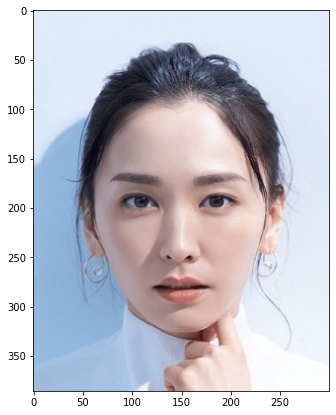

In [12]:
#image source: https://mydramalist.com/people/461-aragaki-yui
img_path = "./data/gakki.jpg"
img_path2 = "/Users/joeljohnson/Desktop/data/Face_Segments/img/060037_4_028465_FEMALE_23.jpg"
img_ori = skimage.io.imread(img_path)
imshow(img_ori)

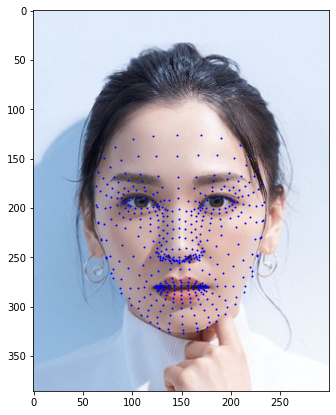

In [13]:
img = img_ori
# img = masked_image
H,W,_ = img.shape
#run facial landmark detection
with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        results = face_mesh.process(img)

assert len(results.multi_face_landmarks)==1 

face_landmarks = results.multi_face_landmarks[0]
keypoints = np.array([(W*point.x,H*point.y) for point in face_landmarks.landmark[0:468]])#after 468 is iris or something else
ax = imshow(img)
ax.plot(keypoints[:, 0], keypoints[:, 1], '.b', markersize=2)
plt.show()


<ipython-input-14-6bf8998fc0d0>:6: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  tform.estimate(keypoints_uv,keypoints)


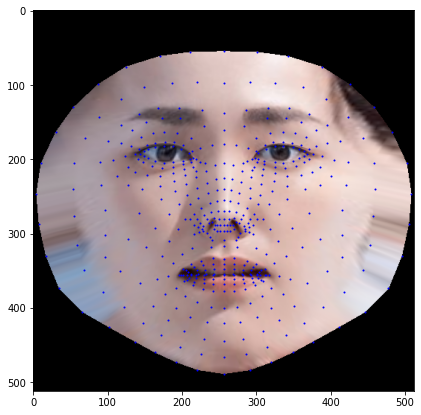

In [14]:
#https://scikit-image.org/docs/dev/auto_examples/transform/plot_piecewise_affine.html
H_new,W_new = 512,512
keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])

tform = PiecewiseAffineTransform()
tform.estimate(keypoints_uv,keypoints)
texture = warp(img_ori, tform, output_shape=(H_new,W_new))
texture = (255*texture).astype(np.uint8)

ax = imshow(texture)
ax.plot(keypoints_uv[:, 0], keypoints_uv[:, 1], '.b', markersize=2)
plt.show()

In [15]:
keypoints3d = np.array([(point.x,point.y,point.z) for point in face_landmarks.landmark[0:468]])

In [16]:
obj_filename = "./data/canonical_face_model.obj"
# obj_filename = "/Users/joeljohnson/Desktop/mediapipe-facemesh/data/head_template.obj"
verts,uvcoords,faces,uv_faces = load_obj(obj_filename)

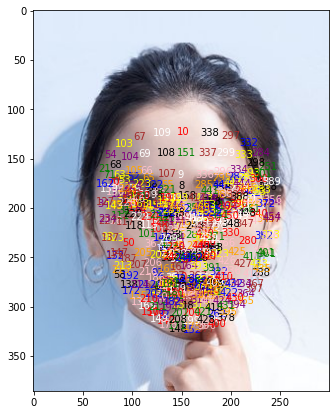

[219 191 187]
[219 191 187]
[172.4 145.6 144.7]
1 [180 150 142] 95.43397717794221
3 [176 148 147] 37.42918647259093
28 [125  97  96] 49.79296134997724
32 [165 139 140] 76.5601658827881
34 [160 149 157] 34.90191971797509
44 [179 145 143] 85.10551685995446
51 [180 155 151] 61.416317050112674
61 [76 48 45] 78.33060704475842
76 [76 48 45] 78.33060704475842
94 [181 140 136] 13.954891615488082
111 [161 135 136] 99.91615985414997
114 [177 146 141] 37.26981352247425
122 [178 150 147] 68.72768001322305
125 [180 145 143] 98.96324570263442
126 [178 147 144] 74.03008847759126
128 [180 147 142] 95.06862784325855
133 [78 50 47] 60.39862581218561
150 [152 126 125] 89.9232116864167
201 [175 147 144] 33.34559940981715
218 [177 148 144] 60.64551920793483
220 [168 146 149] 15.585377762505207
296 [177 152 148] 45.08879018115232
373 [176 146 146] 44.663900411853724
374 [179 154 150] 56.31792787381267
380 [176 148 145] 47.8663138334256
381 [173 143 145] 8.640543964357656
442 [181 146 140] 96.85173720692883


<ipython-input-17-88dccda50c9c>:47: RuntimeWarning: invalid value encountered in double_scalars
  d = sum((2+rm,4,3-rm)*(rgb1-rgb2)**2)**0.5


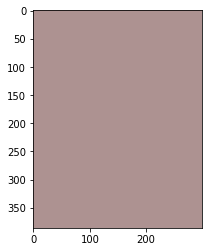

In [17]:
def normalize_keypoints(keypoints3d):
    center = keypoints3d[0]
    keypoints3d = keypoints3d - center
    axis1 = keypoints3d[165] - keypoints3d[391]
    axis2 = keypoints3d[2] - keypoints3d[0]
    axis3 = np.cross(axis2,axis1)
    axis3 = axis3/np.linalg.norm(axis3)
    axis2 = axis2/np.linalg.norm(axis2)
    axis1 = np.cross(axis3, axis2)
    axis1 = axis1/np.linalg.norm(axis1)
    U = np.array([axis3,axis2,axis1])
    keypoints3d = keypoints3d.dot(U)
    keypoints3d = keypoints3d - keypoints3d.mean(axis=0)
    return keypoints3d

vertices = normalize_keypoints(keypoints3d)

# borrowed from https://github.com/YadiraF/PRNet/blob/master/utils/write.py
obj_name =  "./results/obj_model.obj"
# obj_name2 = "/Users/joeljohnson/Desktop/mediapipe-facemesh/data/head_template.obj"
write_obj(obj_name,
              vertices,
              faces,
              texture_name = "./results/texture3.jpg",
              texture=texture,
              uvcoords=uvcoords,
              uvfaces=uv_faces,
              )

#print landmarks with labels on image
ax = imshow(img_ori)
colors = ['red','green','blue','yellow','purple','orange','pink','brown','black','white']
pixels = {}
for i in range(len(keypoints)-2):
    # confidence = face_landmarks.landmark[i].visibility
    # if confidence < 0.5:
    #     print(i,confidence)
    c = colors[i%len(colors)]
    pixels[i] = img_ori[int(keypoints[i,1]),int(keypoints[i,0])]
    ax.text(keypoints[i,0], keypoints[i,1], str(i), color=c)
    
plt.show()

def ColorDistance(rgb1,rgb2):
    '''d = {} distance between two colors(3)'''
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = sum((2+rm,4,3-rm)*(rgb1-rgb2)**2)**0.5
    return d
#print average pixel for skin
#show skin pixel at landmark 109
print(img_ori[int(keypoints[109,1]),int(keypoints[109,0])])

print(pixels[109])
#average skin pixel
print(np.mean([pixels[i] for i in range(100,120)],axis=0))
mean  = np.mean([pixels[i] for i in range(100,120)],axis=0)
min = 10000
close_pixels = []
for p in pixels:
    d = ColorDistance(pixels[p],mean)
    if d < 100:
        print(p,pixels[p],d)
        min = d
        close_pixels.append(pixels[p])
#sort by distance
close_pixels = sorted(close_pixels,key=lambda x: ColorDistance(x,mean))

print(close_pixels)
mean  = np.mean(close_pixels[:10],axis=0)
arr = np.empty_like(img_ori)
for i in range(img_ori.shape[0]):
    for j in range(img_ori.shape[1]):
        arr[i,j] = mean
plt.imshow(arr)
plt.show()



In [18]:
#Import Libraries
import os,argparse,uuid
import dlib,cv2,filetype
import numpy as np
from imutils import face_utils
import config
import webcolors
from sklearn.cluster import KMeans
from collections import Counter


#Landmark's facial detector to estimate the location of 68 coordinates that map the facial points
#in a person's face
FACIAL_LANDMARK_PREDICTOR = os.path.join(img_path,'shape_predictor_68_face_landmarks.dat')

# Defining the HSV Thresholds representing the HSV pixel intensities to be considered skin
LOWER_THRESHOLD = np.array([0, 48, 80], dtype=np.uint8)
UPPER_THRESHOLD = np.array([20, 255, 255], dtype=np.uint8)


def initialize_dlib(facial_landmark_predictor:str):
    """
    Initialize dlib's face detetctor (HOG-based) and then create the facial landmark predictor
    """
    print('Loading facial landmark predictor...')
    detector  = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)

    return detector, predictor

"""
def top_image_colors(img,n):
    import pandas as pd
    #Convert the image to RGB
    image = img.convert('RGB')

    detected_colors = []
    for x in range(image.width):
        for y in range(image.height):
            (a,b,c) = image.getpixel((x,y))
            if a != 0 and b!=0 and c!=0:
                detected_colors.append(find_color( (a,b,c) ))
    Series_Colors = pd.Series(detected_colors)
    output = Series_Colors.value_counts()/len(Series_Colors)
    l_colors = output.reset_index().values.tolist()
    top_color_name  = l_colors[0][0]
    top_color_score = round(l_colors[0][1] * 100 ,0)
    return top_color_name, top_color_score
"""
def extract_faces_landmarks(img, detector, predictor):
    # Convert image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the gray scale frame
    faces = detector(img_gray, 0)

    for idx, face in enumerate(faces):
        landmarks = predictor(img_gray, face)
        landmarks_points = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points.append((x, y))
        yield {
                "face": face
                , "landmarks": landmarks_points
        }

def mask_landmark(img,pts):
    # Create a mask
    mask = np.ones(img.shape[:2],np.uint8) #np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask,[pts],-1,(0,0,0),-1,cv2.LINE_AA)
    masked_img = cv2.bitwise_and(img,img,mask=mask)
    return masked_img

def extract_face_skin_area(img,landmarks_points,shape,face_landmarks,face):
    #print('landmarks', landmarks_points)
    #print('shape', shape)
    #print('face_landmarks', face_landmarks)
    #print('face', face)

    # Convert image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_mask = np.zeros_like(img_gray)
    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    head_mask = cv2.fillConvexPoly(face_mask, convexhull, 255)
    masked_img = cv2.bitwise_and(img,img, mask=head_mask)

    for name, (i, j) in (
              face_landmarks[0]  # mouth
            , face_landmarks[1]  # inner_mouth
            , face_landmarks[2]  # right_eyebrow
            , face_landmarks[3]  # left_eyebrow
            , face_landmarks[4]  # right_eye
            , face_landmarks[5]  # left_eye
            ):
        pts = np.array([shape[i:j]])
        masked_img = mask_landmark(masked_img, pts)

    (x, y, w, h) = face_utils.rect_to_bb(face)
    print('x, y, w, h', x, y, w, h)
    x = 0 if x < 0 else x
    y = 0 if y < 0 else y
    masked_face = masked_img[y:y + h, x:x + w]
    return masked_face


def threshold_face_skin_area(img):
    """
    Perform thresholding based on the range of the thresholds specified to extract pixels
    that corresponds to the skin color range.
    Take an 8 bit 3 channel image in BGR colorspace and returns the extracted image in the
    same colorspace.
    """
    # Take a copy of the image
    img = img.copy()

    # Converting from BGR Colors Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Single Channel mask,denoting presence of colors in the about threshold
    skinMask = cv2.inRange(img, LOWER_THRESHOLD,UPPER_THRESHOLD)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

def remove_black_areas(estimator_labels, estimator_cluster):
    """
    Remove out the black pixel from skin area extracted
    By default OpenCV does not handle transparent images and replaces those with zeros (black).
    Useful when thresholding is used in the image.
    """
    # Check for black
    hasBlack = False

    # Get the total number of occurence for each color
    occurence_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    compare = lambda x, y: Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurence_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurence
            del occurence_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurence_counter, estimator_cluster, hasBlack)


def get_color_information(estimator_labels, estimator_cluster, hasThresholding=False):
    """
    Extract color information based on predictions coming from the clustering.
    Accept as input parameters estimator_labels (prediction labels)
                               estimator_cluster (cluster centroids)
                               has_thresholding (indicate whether a mask was used).
    Return an array the extracted colors.
    """
    # Variable to keep count of the occurence of each color predicted
    occurence_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurence, cluster, black) = remove_black_areas(estimator_labels, estimator_cluster)
        occurence_counter = occurence
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurence_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurences
    totalOccurence = sum(occurence_counter.values())

    # Loop through all the predicted colors
    for x in occurence_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index - 1) if ((hasThresholding & hasBlack) & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1] / totalOccurence)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color, "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extract_dominant_colors(image, number_of_colors=5, hasThresholding=False):
    """
    Putting all together.
    Accept as input parameters image -> the input image in BGR format (8 bit / 3 channel)
                                     -> the number of colors to extracted.
                                     -> hasThresholding indicate whether a thresholding mask was used.
    Leverage machine learning by using an unsupervised clustering algorithm (Kmeans Clustering) to cluster the
    image pixels data based on their RGB values.
    """
    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colors Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0] * img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Color Information
    colorInformation = get_color_information(estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def get_top_dominant_color(dominant_colors):
    def find_closest_color(req_color):
        # This is the function which converts an RGB pixel to a color name
        min_colors = {}
        for name, key in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(name)
            rd = (r_c - req_color[0]) ** 2
            gd = (g_c - req_color[1]) ** 2
            bd = (b_c - req_color[2]) ** 2
            min_colors[(rd + gd + bd)] = key
            closest_name = min_colors[min(min_colors.keys())]
        return closest_name

    #print(dominant_colors[0].get('cluster_index'))
    #print(dominant_colors[0].get('color'))
    #print(dominant_colors[0].get('color_percentage'))

    color_value = (
                   int(dominant_colors[0].get('color')[2])
                 , int(dominant_colors[0].get('color')[1])
                 , int(dominant_colors[0].get('color')[0])
                  )
    closest_color_name = find_closest_color(
        (
            int(dominant_colors[0].get('color')[0])
           ,int(dominant_colors[0].get('color')[1])
           ,int(dominant_colors[0].get('color')[2])
        )
    )
    color_score = round( dominant_colors[0].get('color_percentage') * 100,2)
    return color_value, closest_color_name, color_score




"""
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0), (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar
"""

def detect_skin_color(input_path:str,display_output:bool = False):
    """
    Detect Face Skin Color
    """
    #Initialize dlib face detector using the facial landmark recognition
    detector, predictor = initialize_dlib(facial_landmark_predictor=FACIAL_LANDMARK_PREDICTOR)

    # Read Input Image
    img = cv2.imread(input_path)

    # Preserve a copy of the original
    frame = img.copy()

    # Convert it to gray scale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    output      = []
    output_info = []

    # Loop over the faces detected
    for idx, face_landmarks in enumerate(extract_faces_landmarks(frame, detector, predictor)):
        frame = img.copy()

        face = face_landmarks['face']
        landmark_points = face_landmarks['landmarks']
        #print('landmark_points', landmark_points)

        output_msg = {'msg': "Face {} detected on position (Left:{} Top:{} Right:{} Botton:{}).".\
                                format((idx+1), face.left(), face.top(), face.right(), face.bottom())
                    , 'category': "info"}
        output_info.append(output_msg)
        print(output_msg.get('category'), output_msg.get('msg'))

        #Determine the facial landmarks for the face region
        #Convert the facial landmarks to a Numpy Array
        shape = predictor(gray_frame,face)
        shape = face_utils.shape_to_np(shape)

        # List containing the facial features
        face_landmarks = list(face_utils.FACIAL_LANDMARKS_IDXS.items())

        #Draw the face bounding box
        (x,y,w,h) = face_utils.rect_to_bb(face)
        startX, startY, endX, endY = x, y, (x + w), (y + h)

        #Extract Face Skin Area
        face_skin_area = extract_face_skin_area(frame,landmark_points, shape, face_landmarks,face)

        #Threshold Skin Area
        thresholded_skin = threshold_face_skin_area(face_skin_area)

        dominant_colors = extract_dominant_colors(thresholded_skin,number_of_colors=5,hasThresholding=True)

        color_value, closest_color_name, color_score = get_top_dominant_color(dominant_colors)

        cv2.rectangle(frame, (startX, startY), (endX, endY), color_value, 5)

        label = "{}-{:.2f}%".format(closest_color_name,color_score)
        print(label)
######################
        output_filepath = os.path.join(config.PROCESSED_PATH,
                                           str(uuid.uuid4().hex) + os.path.splitext(input_path)[1])
        cv2.imwrite(output_filepath, frame)
        output_item = {'id': 1, 'folder': config.PROCESSED_FOLDER
                              , 'name': os.path.basename(output_filepath)
                              , 'msg': os.path.basename(output_filepath)}
        output.append(output_item)

        output_filepath = os.path.join(config.PROCESSED_PATH,
                                           str(uuid.uuid4().hex) + os.path.splitext(input_path)[1])
        cv2.imwrite(output_filepath, thresholded_skin)
        output_item = {'id': 2, 'folder': config.PROCESSED_FOLDER
                              , 'name': os.path.basename(output_filepath)
                              , 'msg': label}
        output.append(output_item)
######################

        if display_output:
           # Display Image on screen
           cv2.imshow(label, frame)
           cv2.waitKey(0)

    if display_output:
       # Cleanup
       cv2.destroyAllWindows()

    return output_info , output


def is_valid_path(path):
    """
    Validates the path inputted and makes sure that is a file of type image
    """
    if not path:
        raise ValueError(f"Invalid Path")
    if os.path.isfile(path) and 'image' in filetype.guess(path).mime:
       return path
    else:
       raise ValueError(f"Invalid Path {path}")


def parse_args():
    """
    Get user command line parameters
    """
    parser = argparse.ArgumentParser(description="Available Options")

    parser.add_argument('-i'
                       ,'--input_path'
                       ,dest='input_path'
                       ,type=is_valid_path
                       ,required=True
                       ,help = "Enter the path of the image file to process")

    parser.add_argument('-d'
                        , '--display_output'
                        , dest='display_output'
                        , default=False
                        , type=lambda x: (str(x).lower() in ['true', '1', 'yes'])
                        , help="Display output on screen")

    args = vars(parser.parse_args())

    #To Display The Command Line Arguments
    print("## Command Arguments #################################################")
    print("\n".join("{}:{}".format(i,j) for i,j in args.items()))
    print("######################################################################")

    return args

if __name__ == '__main__':
    # Parsing command line arguments entered by user
    # args = parse_args()
    detect_skin_color(input_path  = img_path)



ModuleNotFoundError: No module named 'dlib'

: 